In [ ]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch
if torch.cuda.is_available():    
    dev = torch.device("cuda")
else:
    dev = torch.device("cpu")

# dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook
root_dir = '/global/cfs/cdirs/lsst/www/shivamp/CAMELS_NPE/'
os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




In [52]:
ji = 0
ns_d = 128
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['cnn', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
# z_all = [0, 0.5, 127]
# fields_all = ['Mtot','Mgas','ne', 'T','P']
fields_all = ['Mtot','Mgas']
ns_h = 128
# ns_h = 256
nax_h = ns_h // nb

# nsims_per_batch = 512
# nsims_per_batch = 128
nsims_per_batch = 256
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 1


In [ ]:
# print(nbatches_train)
print(dev)



In [4]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 3
nflows_M1_NSF = 5
K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 6
base_dist_M1 = 'gumbel'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5
changelr = False
ksize = nf
nfeature_cnn = 3
nout_cnn = 4 * nfeature_cnn
ninp = 1
# num_cond = nout_cnn + ninp
num_cond = nout_cnn



In [5]:
# Load the density data
df_d_all_train, df_pred_all_train, min_val_Mtot_tosub_train, min_vals_fields_tosub_train, sig_val_Mtot_todiv_train, sig_vals_fields_todiv_train = load_density_halo_data(
    ji, ns_d, nb, nf, nc, fields_all
    )

# Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_pred_all_train, nsims=nsims_per_batch,
    nbatches = nbatches_train
    )




0 128


In [6]:
sig_val_Mtot_todiv_train


1.2426513101974175

In [7]:
# return_dict_train['df_d_all'][0].shape
# return_dict_train.keys()
# np.array(return_dict_train['df_pred_all']).shape
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_pred_all'])[...,1].flatten()
# min_vals_fields_tosub_train
# min_val_Mtot_tosub_train


(1, 128, 22, 22, 22)

Text(0, 0.5, 'Histogram')

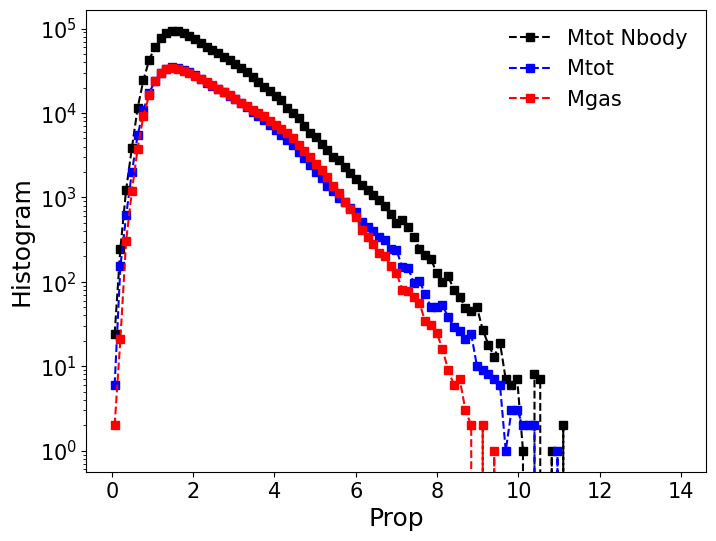

In [12]:
# len(return_dict_train['df_pred_all'])
# delta_min_p, delta_max_p = 10.5, 50.4
# indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
# bin_edges = np.linspace(-10,40,1000)
bin_edges = np.linspace(0,14,100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])

hist_truth, _ = np.histogram(np.array(return_dict_train['df_d_all']).flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Mtot Nbody')

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,0].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label='Mtot')

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,1].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label='Mgas')

pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'Prop', size=18)
pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [41]:
np.std(return_dict_train['df_pred_all'][...,0].flatten())


1.105160053153131

In [42]:
np.std(return_dict_train['df_pred_all'][...,4].flatten())




1.104610217515631

Text(0, 0.5, 'Histogram')

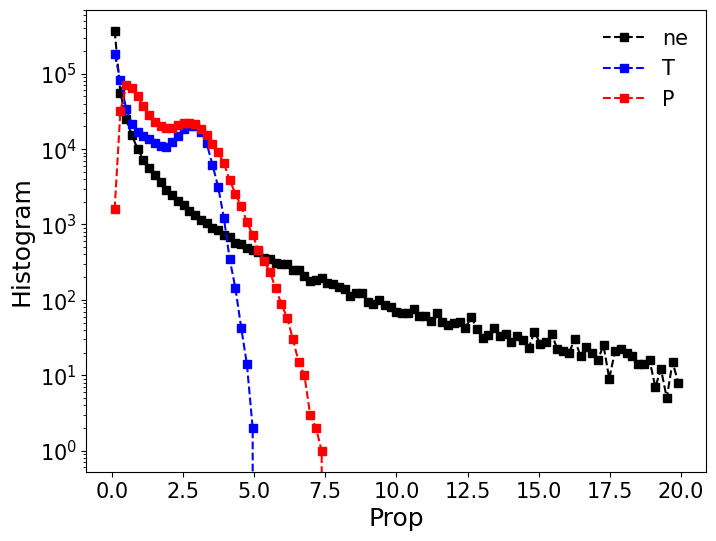

In [13]:
# len(return_dict_train['df_pred_all'])
# delta_min_p, delta_max_p = 10.5, 50.4
# indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
# bin_edges = np.linspace(-10,40,1000)
bin_edges = np.linspace(0,20,100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,2].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='ne')

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,3].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label='T')

hist_truth, _ = np.histogram(np.array(return_dict_train['df_pred_all'])[...,4].flatten(), bins=bin_edges)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label='P')

pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'Prop', size=18)
pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




In [14]:
# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     # base_dist=None
#     base_dist='pl_exp'    
#     )
# # model_Ntot.to(dev)

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond + 1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     mu_pos=False
#     )
# model_M1.to(dev)

ndim_diff = return_dict_train['df_pred_all'][0].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    # num_cond=num_cond + 2,
    num_cond=num_cond,    
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
model_Mdiff.to(dev)

print()



In [15]:
# return_dict_train['df_pred_all'][0].shape[2]
# ndim_diff
num_cond


12

In [16]:
ndim = ndim_diff
model = COMBINED_Model(
    # None, 
    model_Mdiff,
    # None,
    # model_M1,
    # model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    # sep_Ntot_cond=True,
    # sep_M1_cond=True,
    sep_Mdiff_cond=True,
    )

model.to(dev)

print()




In [17]:
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_d_all_nsh']).shape


(1, 128, 22, 22, 22)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20


# cond_tensor = torch.Tensor(np.moveaxis(np.array(return_dict_train['df_d_all']), 0, 1)).cuda(dev)
cond_tensor = (np.array(return_dict_train['df_d_all']))
cond_tensor = np.reshape(cond_tensor, (cond_tensor.shape[0], cond_tensor.shape[1], 1, cond_tensor.shape[2], cond_tensor.shape[3], cond_tensor.shape[4]))
# cond_tensor.reshape()
cond_tensor = torch.Tensor(cond_tensor).to(dev)
# cond_tensor = cond_tensor
# cond_tensor_nsh = torch.Tensor(np.copy(return_dict_train['df_d_all_nsh'].reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
# cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
print(cond_tensor.shape)
# cond_tensor_nsh = torch.Tensor(np.array(cond_nsh).reshape(nbatches_train,nsims_per_batch * (nax_h ** 3), ninp)).cuda(dev)
# mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1']).reshape(nbatches_train,nsims_per_batch * (nax_h**3))).cuda(dev)

# X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1))).cuda(dev)
# X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)).cuda(dev)
X_Mdiff = torch.Tensor(np.array(return_dict_train['df_pred_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff)).to(dev)

mask_tensor_Mdiff_train = torch.ones_like(X_Mdiff)

# Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)))).cuda(dev)






torch.Size([1, 128, 1, 22, 22, 22])


In [19]:
# cond_tensor.reshape()


In [20]:
# # print(X_Mdiff.shape)
# X_Mdiff = torch.Tensor(np.array(return_dict_train['df_pred_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
#                                                                                  ndim_diff)).cuda(dev)



In [21]:
# nax_h


In [22]:
# np.array(return_dict_train['df_pred_all']).shape


In [37]:
# save_bestfit_model_name = 'FINAL_COMBINED/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
#                 str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
save_bestfit_model_name = '/global/cfs/cdirs/lsst/www/shivamp/CAMELS_NPE/nf/save_check/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(8)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [24]:
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0



In [25]:
# cond_tensor.shape
# 16 * 32 * 3 * 70 * 70 * 70
# cond_tensor.shape


In [47]:
ninit = 0
niterations = 300

# torch.autograd.set_detect_anomaly(False)
for ito in tqdm(range(niterations)):
    optimizer.zero_grad()
    for g in optimizer.param_groups:
        g['lr'] = 0.00075

    it = ito + ninit

    loss = model(
        X_Mdiff,
        cond_x=cond_tensor,
        mask_Mdiff_truth_all=mask_tensor_Mdiff_train,
        )

    loss.backward()
    optimizer.step()

    if (np.mod(it, int(niterations / 20)) == 0) or (it == niterations - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 4))
            # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

            torch.save(
                state, save_bestfit_model_name
                )


            

 10%|█         | 31/300 [00:07<01:14,  3.59it/s]

saving bf at: , with loss: -4.3109


 15%|█▌        | 46/300 [00:11<01:09,  3.67it/s]

saving bf at: , with loss: -4.3701


 20%|██        | 61/300 [00:15<01:05,  3.65it/s]

saving bf at: , with loss: -4.429


 25%|██▌       | 76/300 [00:19<01:01,  3.65it/s]

saving bf at: , with loss: -4.4876


 80%|████████  | 241/300 [01:01<00:16,  3.67it/s]

saving bf at: , with loss: -4.5301


 85%|████████▌ | 256/300 [01:05<00:12,  3.59it/s]

saving bf at: , with loss: -4.5878


 90%|█████████ | 271/300 [01:09<00:08,  3.62it/s]

saving bf at: , with loss: -4.6438


 95%|█████████▌| 286/300 [01:13<00:04,  3.39it/s]

saving bf at: , with loss: -4.6646


100%|██████████| 300/300 [01:16<00:00,  3.91it/s]


In [48]:
# cond_tensor.shape
# train_M1
# mask_tensor_Mdiff_train.shape


In [49]:
cond_tensor = cond_tensor.to(dev)
# cond_tensor_nsh = cond_tensor_nsh.to(dev)
M_diff_samp = model.inverse(
        cond_x=cond_tensor,
        mask_Mdiff_truth=mask_tensor_Mdiff_train[0,...],
        )








In [24]:
# train_Mdiff
# Nhalos_truth_tensor.shape
# 2097152/1048576
# mask_tensor_M1_train.shape, X_M1.shape
# cond_tensor.shape
# nsim * nvox // nbatches
# 128**3//8


In [25]:
# np.amin(cond_tensor_nsh.cpu().detach().numpy()[:,0])


In [26]:
# pl.figure()
# jb = 0
# indsel = np.where(cond_tensor_nsh[jb].cpu().detach().numpy()[:,0] > 0.0)
# _ = pl.hist(Ntot_samp[jb][indsel], histtype='step', bins=[0,1,2,3,4,5,6,7])
# _ = pl.hist(Nhalos_truth_tensor[jb].cpu().detach().numpy()[indsel], bins=[0,1,2,3,4,5,6,7])
# # xarr = np.arange(9)
# # yarr = 4e5*np.exp(-xarr)
# # al, bt = 0.0, 1.5
# # yarr = 4e5*np.power(1+xarr, al) * np.exp(-bt * xarr)
# # yarr = 4e5/xarr**(5)
# # pl.plot(xarr, yarr)
# # _ = pl.hist(X_Nhalo[:,0].cpu().detach().numpy())
# pl.yscale('log')
# pl.xlabel('Nhalo')
# pl.ylabel('Histogram')






In [27]:
# mask_tensor_M1_samp[jb].cpu().detach().numpy().shape


In [28]:
# pl.figure()
# indp = (mask_tensor_M1_samp[jb].cpu().detach().numpy() > 0)
# _ = pl.hist(M1_samp[jb].cpu().detach().numpy()[indp], range=(0,1), histtype='step')
# indp = (mask_tensor_M1_train[jb].cpu().detach().numpy() > 0)
# _ = pl.hist(X_M1[jb][:,0].cpu().detach().numpy()[indp], range=(0,1))
# pl.yscale('log')
# pl.xlabel('M1')
# pl.ylabel('Histogram')








In [29]:
M_diff_samp[0].shape, X_Mdiff[0].shape


(torch.Size([524288, 5]), torch.Size([524288, 5]))

Text(0, 0.5, 'Histogram')

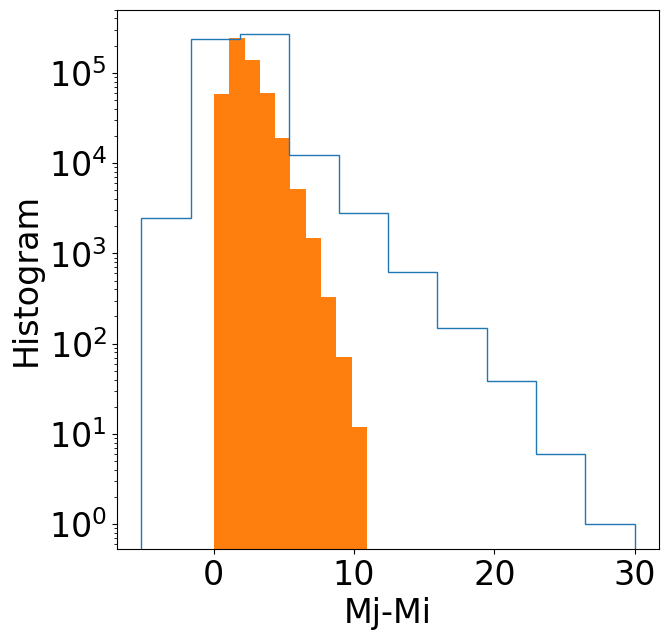

In [50]:
pl.figure()
ind_M = 0
jb = 0
# indp = mask_tensor_Mdiff_train[jb][:, ind_M] > 0
_ = pl.hist(M_diff_samp[jb][:,ind_M].cpu().detach().numpy(), histtype='step')
# indp = mask_tensor_Mdiff_train[jb][:, ind_M] > 0
_ = pl.hist(X_Mdiff[jb][:,ind_M].cpu().detach().numpy())


pl.yscale('log')
pl.xlabel(r'Mj-Mi')
pl.ylabel('Histogram')






In [22]:
# now we load the test data
nstart = 0
nsims_test = 64
df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data(
    1, ns_d, nb, nf, nc, z_all, ns_h
    )

# things are too big to load all at once, so we load in batches
nq = nb**3 // nsims_test
save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
nscount = 0
for jq in range(nq):
    # Load the density data

    # Prepare the density and halo data
    return_dict_test = prep_density_halo_cats(
        df_d_all_test,
        df_d_all_nsh_test,
        df_Mh_all_test,
        df_Nh_test,
        nsims=nsims_test,
        nstart=nscount,
        )

    cond_tensor_test = torch.Tensor(np.copy(return_dict_test['df_d_all'])).cuda(dev)
    cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
    # cond_tensor_nsh_test = torch.Tensor(
    #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
    #     ).cuda(dev)
    mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test = torch.Tensor(
        (return_dict_test['mask_M_diff'].reshape(nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test = torch.Tensor(
        return_dict_test['M_diff_halos_all_norm_masked'].reshape(nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(nsims_test * (nax_h**3),
                                                                                      1)))).cuda(dev)

    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
        cond_x=cond_tensor_test,
        cond_x_nsh=cond_tensor_nsh_test,
        use_truth_Nhalo=False,
        use_truth_M1=False,
        use_truth_Mdiff=False,
        mask_Mdiff_truth=mask_tensor_Mdiff_test,
        mask_M1_truth=mask_tensor_M1_test,
        Nhalos_truth=X_Nhalo_test,
        M1_truth=X_M1_test,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff         
        )
    Ntot_samp_test = Ntot_samp_test[:,np.newaxis]
    # print(Ntot_samp_test.shape)
    save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_M1[nscount:nscount + nsims_test,
                   ...] = (M1_samp_test * mask_tensor_M1_samp_test[:, 0]
                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
    save_subvol_Mdiff[nscount:nscount + nsims_test,
                      ...] = (M_diff_samp_test * mask_tensor_Mdiff_samp_test
                             ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

    mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                     0] = mask_tensor_M1_samp_test[:,
                                                   0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_samp_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
    nscount += nsims_test
    
    
    

0 64


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5